# --------- Pricing Des Options Via Différents Modèles Discrets & Continus ----------

## Elaboré par:
### -Iheb Mensi
### -Marwa Guemira
### -Rimel Morjane


## 1- Installation des Packages 

In [33]:
options(warn=-1)

In [34]:
install.packages("fOptions")
install.packages("timeDate")
install.packages("timeSeries")
install.packages("fBasics")
install.packages("qrmtools")

In [720]:
library(fOptions)
library(timeDate)
library(timeSeries)
library(fBasics)
library(qrmtools)

## 2- Modélisation numérique du modèle Cox Ross Runinstein .
### 2.1-  Creation d'un modèle binômial From scratch 
#### 2.1.1- l’arbre de l’évolution du prix de l’action

In [721]:
build_stock_tree = function(S, sigma, delta_t, N) {
  tree = matrix(0, nrow=N+1, ncol=N+1)
  
  u = exp(sigma*sqrt(delta_t))
  d = exp(-sigma*sqrt(delta_t))
  
  for (i in 1:(N+1)) {
    for (j in 1:i) {
 
      tree[j,i] = S * d^(j-1) * u^((i-1)-(j-1))

    }
  }
 
  return(list(tree=tree,u=u,d=d))
}

In [722]:
Tree_Action=build_stock_tree(S=10, sigma=0.6, delta_t=1/2, N=4)
Tree_Action

10,15.284652,23.362057,35.708091,54.578573
0,6.542511,10.000000,15.284652,23.362057
0,0.000000,4.280445,6.542511,10.000000
0,0.000000,0.000000,2.800486,4.280445
0,0.000000,0.000000,0.000000,1.832221


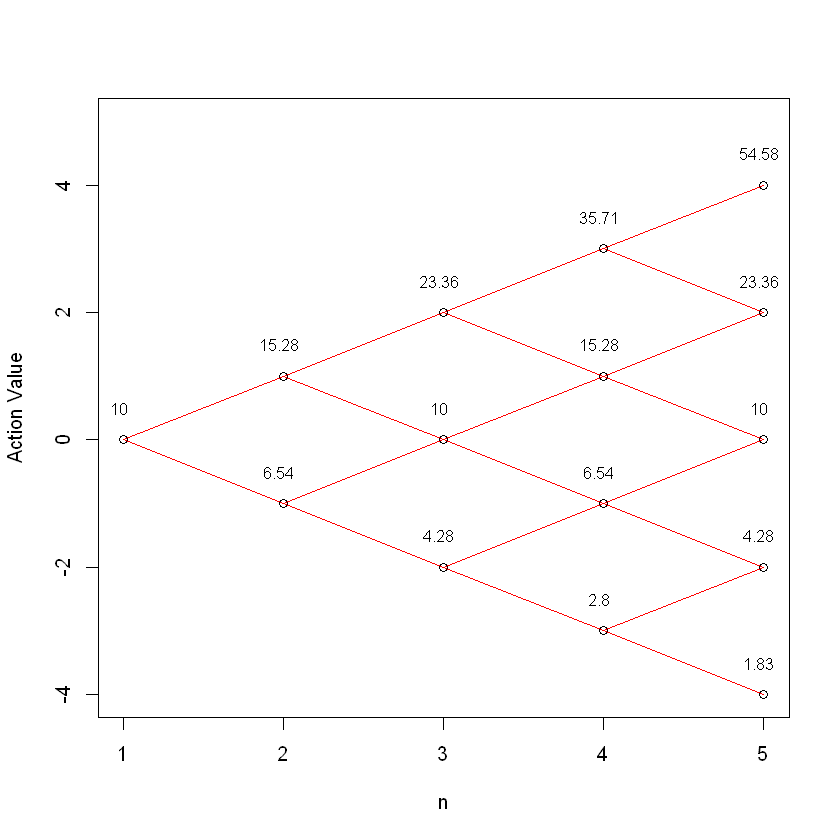

In [723]:
BinomialTreePlot(Tree_Action$tree, dy = 0.5, cex = 0.8, ylim = c(-4, 5),
                 xlab = "n", ylab = "Action Value")

#### 2.1.2- Calcule de l'unique probabilité risque neutre Q

In [724]:
q_prob = function(r, delta_t, sigma) {
  u = exp(sigma*sqrt(delta_t))
  d = exp(-sigma*sqrt(delta_t))
  
  return((exp(r*delta_t) - d)/(u-d))
}

In [725]:
q_prob(0.1, 1/5, 0.2)

[1] 0.5904327

#### 2.1.3- l’arbre de l’évolution du prix de l’option

In [726]:

value_binomial_option = function(Tree_Action, sigma, delta_t, r, K, type) {
  q = q_prob(r, delta_t, sigma)
  R=1+r  
  if((Tree_Action$u>R)&(Tree_Action$d<R)) {
      
  option_tree = matrix(NA,ncol=ncol(Tree_Action$tree), nrow=nrow(Tree_Action$tree)) 
    
  if(type == 'put') {
    option_tree[,nrow(option_tree)] = pmax(K - Tree_Action$tree[,ncol(Tree_Action$tree)], 0)
  } else if(type == 'call') {
    option_tree[,nrow(option_tree)] = pmax(Tree_Action$tree[,ncol(Tree_Action$tree)] - K, 0)
  } else if(type == 'strap') {
    option_tree[,nrow(option_tree)] = pmax((2*Tree_Action$tree[,ncol(Tree_Action$tree)]) - (2*K), 0)
  } else {
     return("il faut choisir call ou put")
  }
  }else {
     return("Hypothèse AOA n \'est pas Vérifié ")
  }
      
  for (i in (nrow(Tree_Action$tree)-1):1) {
    for(j in 1:i) {
      
      option_tree[j, i] = ((1-q)*option_tree[j,i+1] + q*option_tree[j+1,i+1])/exp(r*delta_t)
      
    }
  }
  return(option_tree)
}

In [727]:
tree = build_stock_tree(S=10, sigma=0.8, delta_t=1/5, N=3)
tree_option=value_binomial_option(tree, sigma=0.2, delta_t=1/5, r=0.1, K=10, type='call')
tree_option

2.449177,5.1013335,10.21765,19.250531
NA,0.6932446,1.72682,4.301379
NA,NA,0.00000,0.000000
NA,NA,NA,0.000000


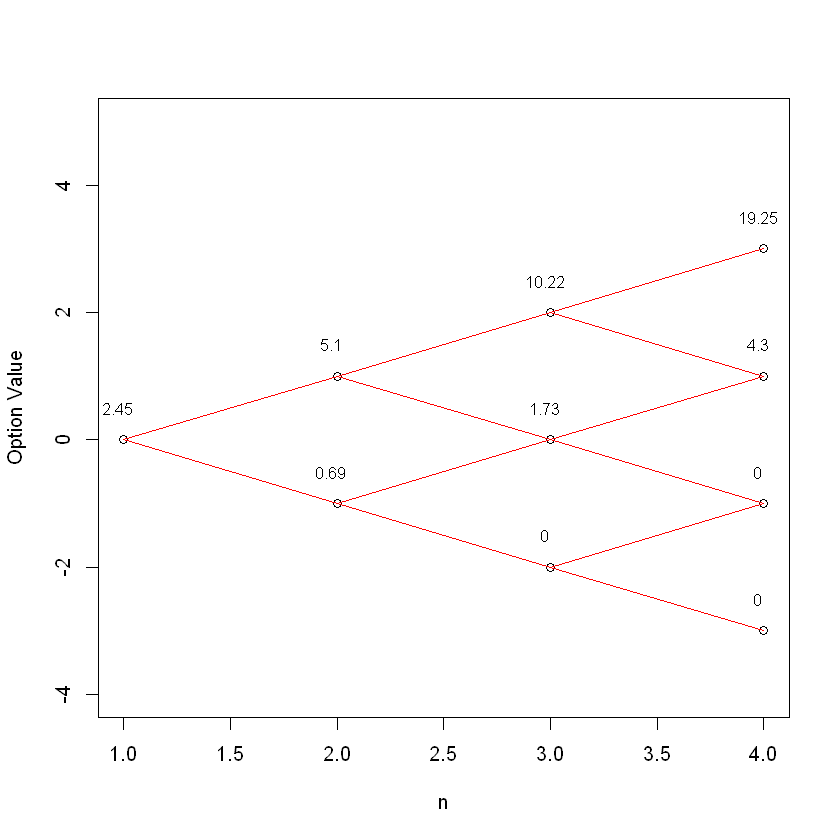

In [728]:
BinomialTreePlot(tree_option, dy = 0.5, cex = 0.8, ylim = c(-4, 5),
                 xlab = "n", ylab = "Option Value")

In [729]:
binomial_option = function(type, sigma, T, r, K, S, N) {
  if(type=="put" | type=="call" | type=="strap"){ 
  q = q_prob(r=r, delta_t=T/N, sigma=sigma)
  tree = build_stock_tree(S=S, sigma=sigma, delta_t=T/N, N=N)
  tree_v=replace(tree$tree,tree$tree==0,".")
  
  option = value_binomial_option(tree, sigma=sigma, delta_t=T/N ,r=r, K=K, type=type)
  option_v=replace(option,is.na(option),".")
  
  delta = (option[2,2]-option[1,2])/(tree$tree[2,2]-tree$tree[1,2])
  tree_action=BinomialTreePlot(tree$tree, dy = 0.5, cex = 0.8, ylim = c(-4, 4),
                 xlab = "n", ylab = "Action Value")
  tree_option=BinomialTreePlot(option, dy = 0.5, cex = 0.8, ylim = c(-4, 4),
                 xlab = "n", ylab = "Option Value")  
   
  return(list(Q=q,U=tree$u , D=tree$d, Tree_Action=tree_v, Tree_Option=option_v, price=option[1,1], delta=delta))
  }
    return("le type est inn")
}

### 2.1.4 Option Call européenne 

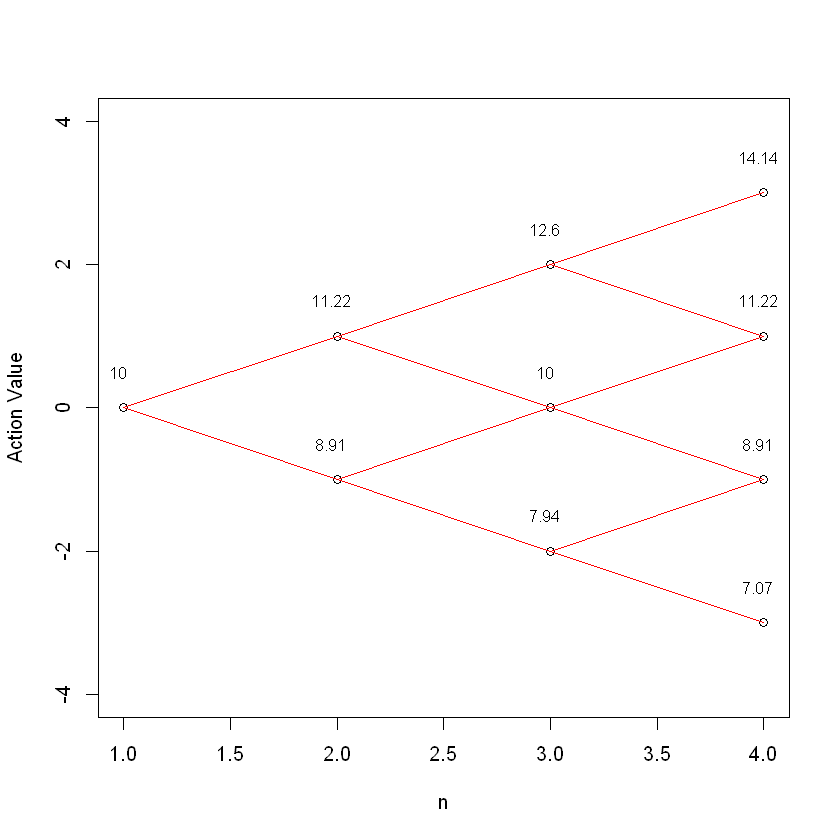

10,11.2240090244567,12.5978378581085,14.1398245808052
.,8.90947252288411,10,11.2240090244567
.,.,7.93787006360269,8.90947252288411
.,.,.,7.07222352218925
0.509505706073843,1.1071545797887,2.26230937002727,4.13982458080516
.,0.167435267857835,0.45270551009493,1.22400902445668
.,.,0,0
.,.,.,0


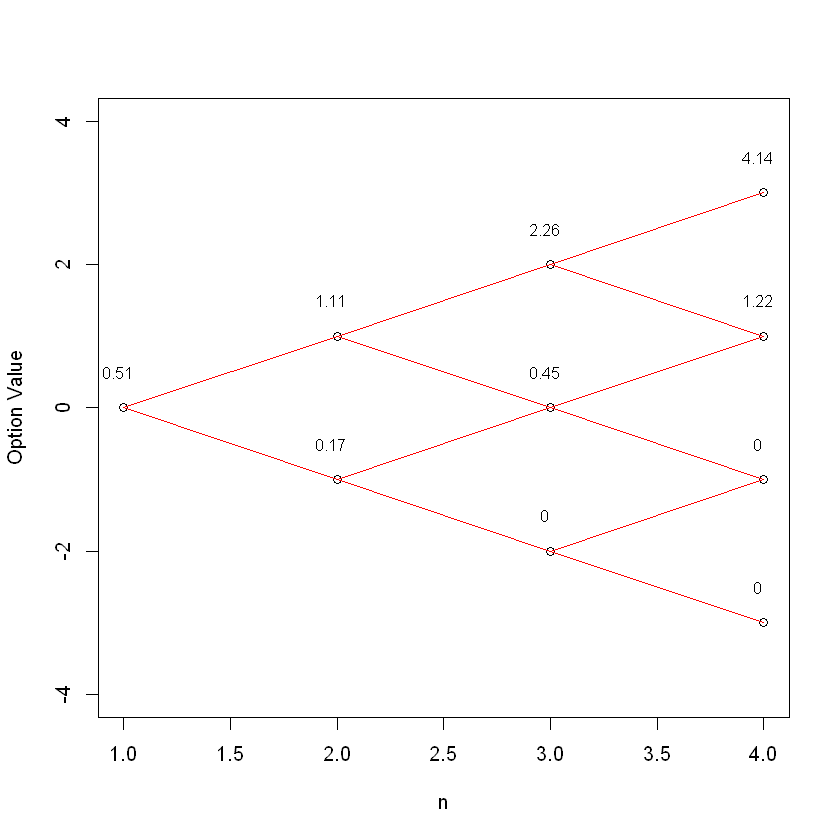

In [730]:
test_call =binomial_option(type='call', sigma=0.2, T=1, r=0.1, K=10, S=10, N=3)
test_call

### 2.1.5 Option Put européenne 

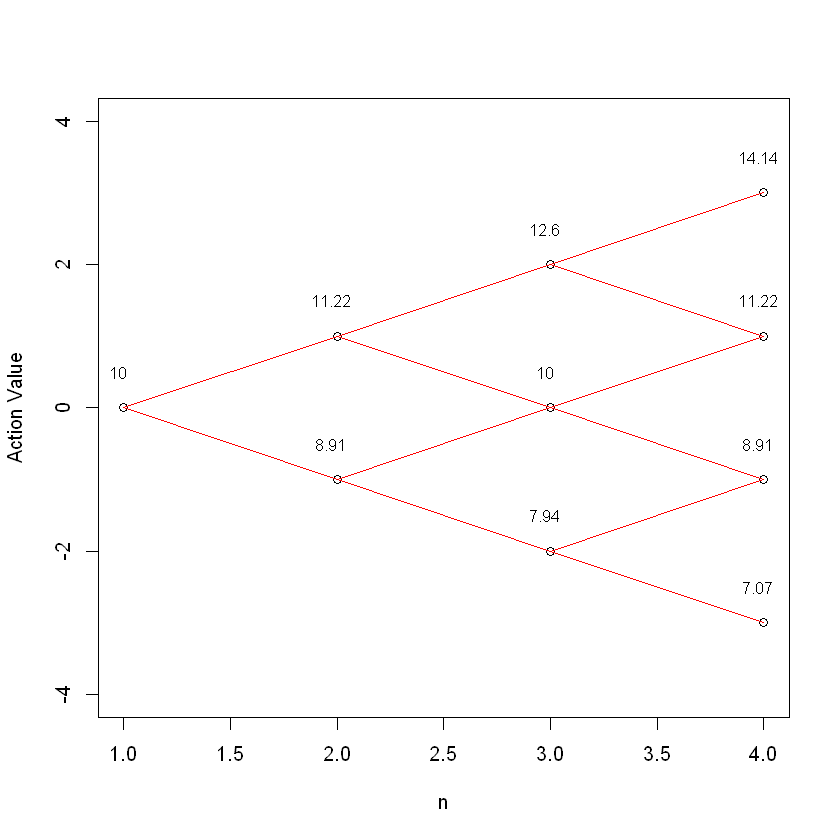

10,11.2240090244567,12.5978378581085,14.1398245808052
.,8.90947252288411,10,11.2240090244567
.,.,7.93787006360269,8.90947252288411
.,.,.,7.07222352218925
1.05587384940473,0.389144505092255,0,0
.,1.52662515967052,0.651439003569612,0
.,.,2.1522773406182,1.09052747711589
.,.,.,2.92777647781075


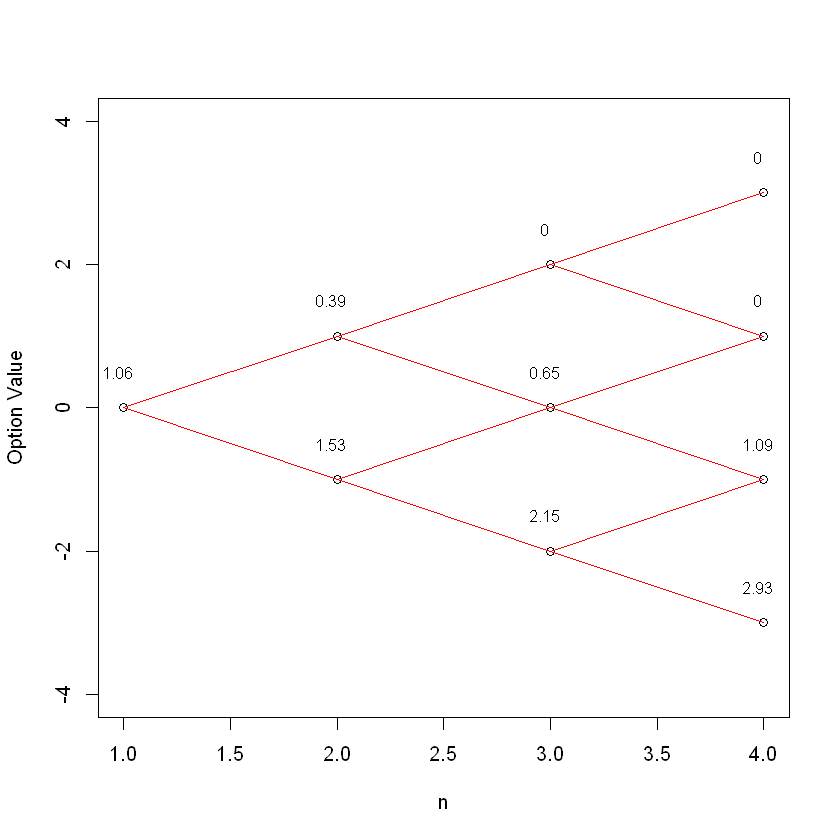

In [731]:
test_call =binomial_option(type='put', sigma=0.2, T=1, r=0.1, K=10, S=10, N=3)
test_call

### 2.1.6 Option Strap européenne 

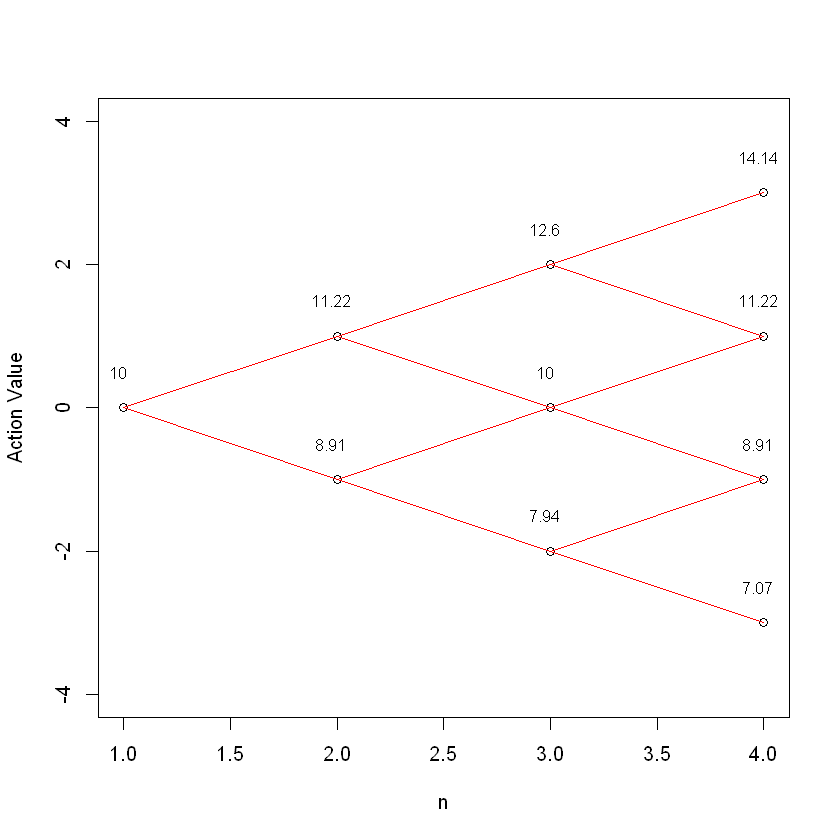

10,11.2240090244567,12.5978378581085,14.1398245808052
.,8.90947252288411,10,11.2240090244567
.,.,7.93787006360269,8.90947252288411
.,.,.,7.07222352218925
1.01901141214769,2.21430915957739,4.52461874005454,8.27964916161033
.,0.334870535715669,0.90541102018986,2.44801804891335
.,.,0,0
.,.,.,0


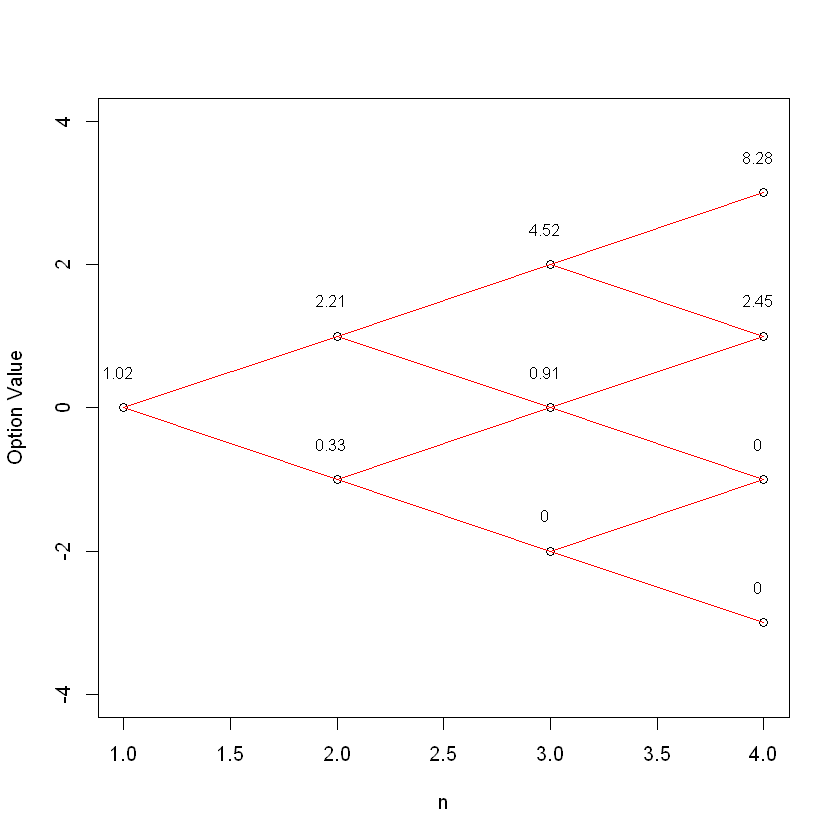

In [732]:
test_call =binomial_option(type='strap', sigma=0.2, T=1, r=0.1, K=10, S=10, N=3)
test_call

## 2.2-  Creation d'un modèle binômial CRR
### 2.2.1-  Creation d'un modèle binômial CRR Option Put Américain

4.488599,2.162590,0.6360052,0.000000,0.000000,0.000000
0.000000,6.959967,3.7712687,1.301712,0.000000,0.000000
0.000000,0.000000,10.3616358,6.378265,2.664213,0.000000
0.000000,0.000000,0.0000000,14.639372,10.311016,5.452843
0.000000,0.000000,0.0000000,0.000000,18.495691,14.639372
0.000000,0.000000,0.0000000,0.000000,0.000000,21.931453


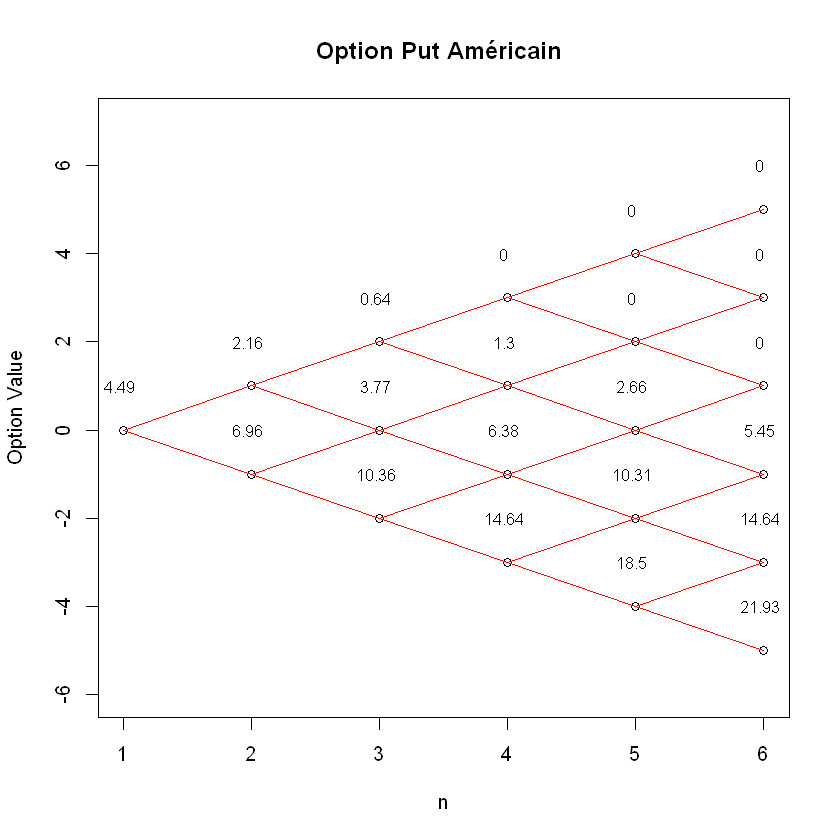

In [733]:
CRRTree = BinomialTreeOption(TypeFlag = "pa", S = 50, 
                                            X = 50, Time = 0.4167, r = 0.1, b = 0.1, sigma = 0.4,n=5)
CRRTree
BinomialTreePlot(CRRTree, dy = 1, cex = 0.8, ylim = c(-6, 7),
                 xlab = "n", ylab = "Option Value")

title(main = "Option Put Américain ")

### 2.2.2-  Creation d'un modèle binômial CRR Option Call Américain

6.359834,9.873817,14.8603783,21.526595,29.769194,39.067666
0.000000,2.849468,4.9068087,8.248509,13.404740,20.700103
0.000000,0.000000,0.7793987,1.549164,3.079181,6.120304
0.000000,0.000000,0.0000000,0.000000,0.000000,0.000000
0.000000,0.000000,0.0000000,0.000000,0.000000,0.000000
0.000000,0.000000,0.0000000,0.000000,0.000000,0.000000


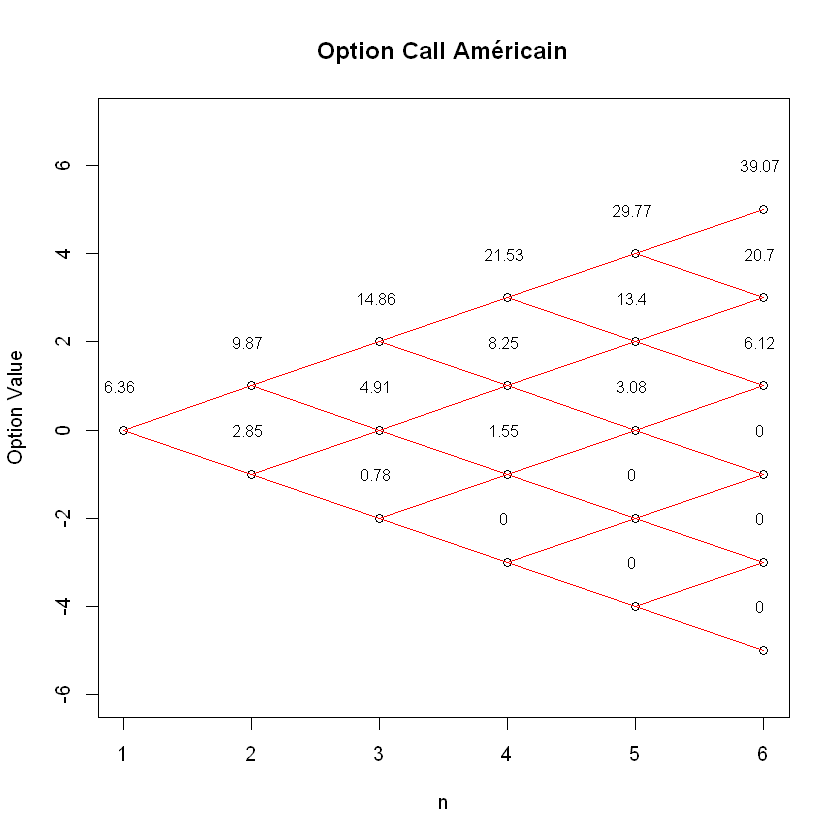

In [734]:
CRRTree = BinomialTreeOption(TypeFlag = "ca", S = 50, 
                                            X = 50, Time = 0.4167, r = 0.1, b = 0.1, sigma = 0.4,n=5)
CRRTree
BinomialTreePlot(CRRTree, dy = 1, cex = 0.8, ylim = c(-6, 7),
                 xlab = "n", ylab = "Option Value")

title(main = "Option Call Américain")

### 2.2.3-  Creation d'un modèle binômial CRR Option Put européen

4.319147,2.114189,0.6360052,0.000000,0.000000,0.000000
0.000000,6.662987,3.6722068,1.301712,0.000000,0.000000
0.000000,0.000000,9.8558131,6.175514,2.664213,0.000000
0.000000,0.000000,0.0000000,13.812879,9.896048,5.452843
0.000000,0.000000,0.0000000,0.000000,18.080723,14.639372
0.000000,0.000000,0.0000000,0.000000,0.000000,21.931453


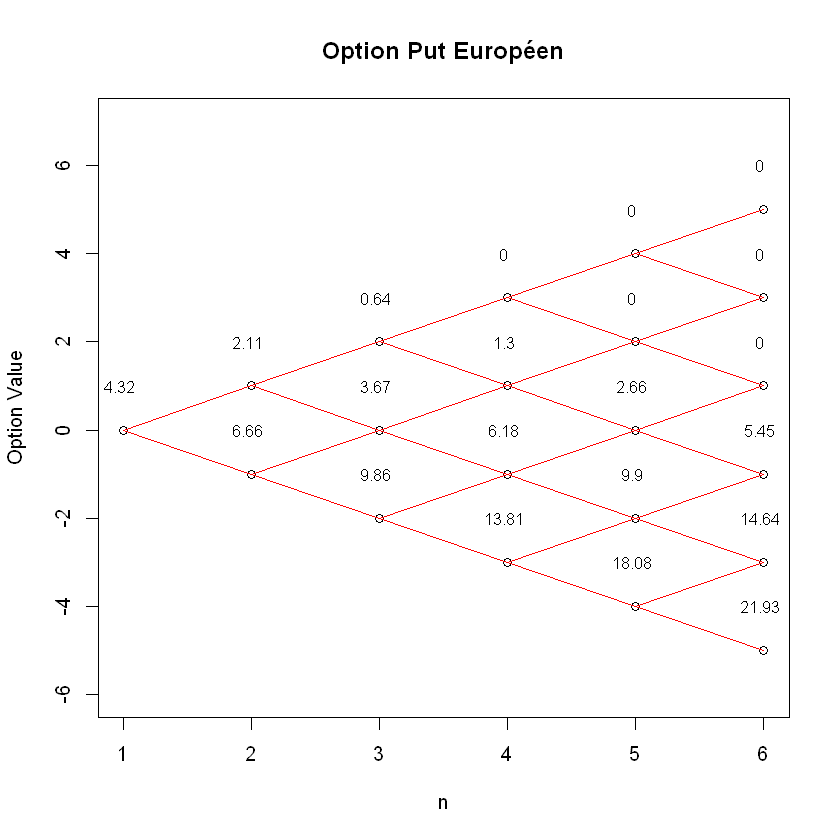

In [735]:
CRRTree = BinomialTreeOption(TypeFlag = "pe", S = 50, 
                                            X = 50, Time = 0.4167, r = 0.1, b = 0.1, sigma = 0.4,n=5)
CRRTree
BinomialTreePlot(CRRTree, dy = 1, cex = 0.8, ylim = c(-6, 7),
                 xlab = "n", ylab = "Option Value")

title(main = "Option Put Européen")

### 2.2.4-  Creation d'un modèle binômial CRR Option Call européen

6.359834,9.873817,14.8603783,21.526595,29.769194,39.067666
0.000000,2.849468,4.9068087,8.248509,13.404740,20.700103
0.000000,0.000000,0.7793987,1.549164,3.079181,6.120304
0.000000,0.000000,0.0000000,0.000000,0.000000,0.000000
0.000000,0.000000,0.0000000,0.000000,0.000000,0.000000
0.000000,0.000000,0.0000000,0.000000,0.000000,0.000000


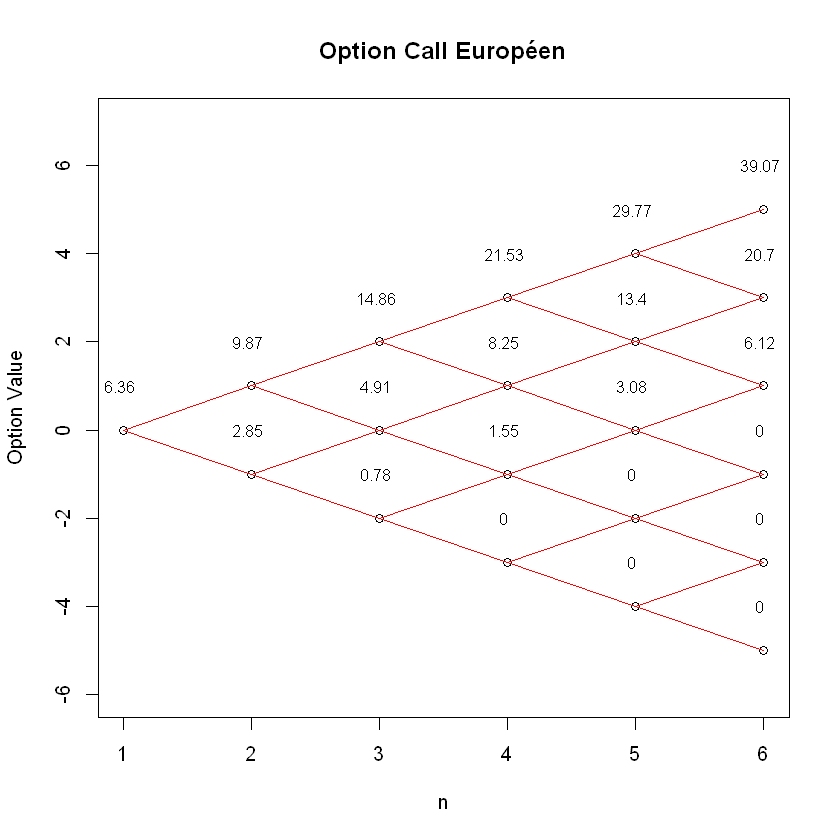

In [736]:
CRRTree = BinomialTreeOption(TypeFlag = "ce", S = 50, 
                                            X = 50, Time = 0.4167, r = 0.1, b = 0.1, sigma = 0.4,n=5)
CRRTree
BinomialTreePlot(CRRTree, dy = 1, cex = 0.8, ylim = c(-6, 7),
                 xlab = "n", ylab = "Option Value")

title(main = "Option Call Européen")

## 2.3 Etude de la volatilité 

CRROptionValue,CRROptionValue1,CRROptionValue2
NA,NA,NA
NA,NA,NA
4.644221,7.341943,8.676587
4.138064,6.495108,7.664248
4.488599,7.103950,8.399861
4.174600,6.575692,7.767191
4.440592,7.008550,8.281537
4.208285,6.619752,7.816413
4.404249,6.949428,8.212344
4.220215,6.643681,7.849260


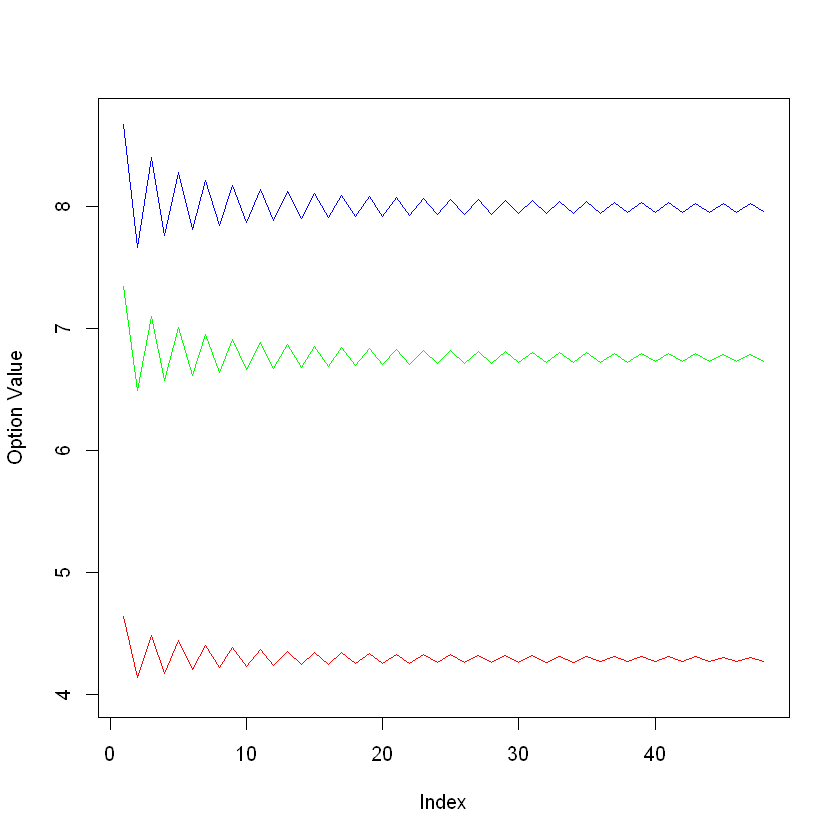

In [737]:
steps = 50
CRROptionValue =  CRROptionValue1 = CRROptionValue2 = rep(NA, times = steps)
for (n in 3:steps) { 
  CRROptionValue[n] = CRRBinomialTreeOption(TypeFlag = "pa", S = 50, 
                                            X = 50, Time = 0.4167, r = 0.1, b = 0.1, sigma = 0.4, n = n)@price
  CRROptionValue1[n] = CRRBinomialTreeOption(TypeFlag = "pa", S = 50, 
                                          X = 50, Time = 0.4167, r = 0.1, b = 0.1, sigma = 0.6, n = n)@price 
  CRROptionValue2[n] = CRRBinomialTreeOption(TypeFlag = "pa", S = 50, 
                                              X = 50, Time = 0.4167, r = 0.1, b = 0.1, sigma =0.7, n = n)@price 
} 
plot(CRROptionValue[3:steps], type = "l", col = "red", ylab = "Option Value",ylim=c(4,8.7))
lines(CRROptionValue1[3:steps],type = "l", col = "green", ylab = "Option Value")
lines(CRROptionValue2[3:steps],type = "l", col = "blue", ylab = "Option Value")
data.frame(CRROptionValue, CRROptionValue1, CRROptionValue2)

## 2.4 Etude de l’effet du taux d’intérêt r 

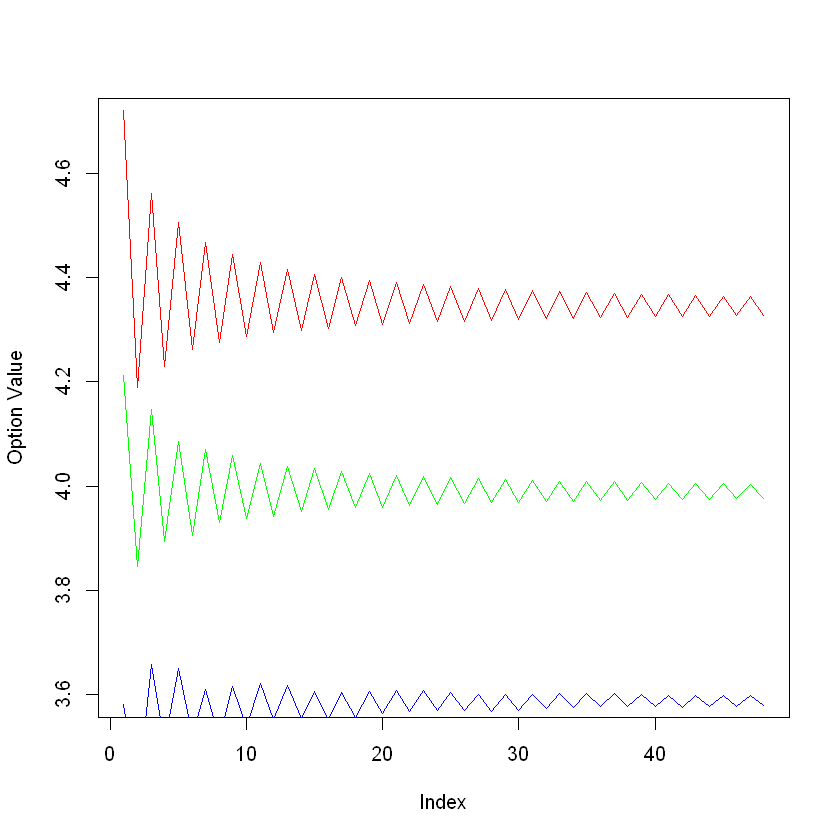

In [738]:
steps = 50
CRROptionValue =  CRROptionValue1 = CRROptionValue2 = rep(NA, times = steps)
for (n in 3:steps) { 
  CRROptionValue[n] = CRRBinomialTreeOption(TypeFlag = "pa", S = 50, 
                                            X = 50, Time = 0.4167, r = 0.05, b = 0.1, sigma = 0.4, n = n)@price
  CRROptionValue1[n] = CRRBinomialTreeOption(TypeFlag = "pa", S = 50, 
                                          X = 50, Time = 0.4167, r = 0.4, b = 0.1, sigma = 0.4, n = n)@price 
  CRROptionValue2[n] = CRRBinomialTreeOption(TypeFlag = "pa", S = 50, 
                                              X = 50, Time = 0.4167, r = 0.9, b = 0.1, sigma = 0.4, n = n)@price 
} 

plot(CRROptionValue[3:steps], type = "l", col = "red", ylab = "Option Value",ylim=c(3.6,4.7))
lines(CRROptionValue1[3:steps],type = "l", col = "green", ylab = "Option Value")
lines(CRROptionValue2[3:steps],type = "l", col = "blue", ylab = "Option Value")


## 2.5 Etude de l’effet de b 

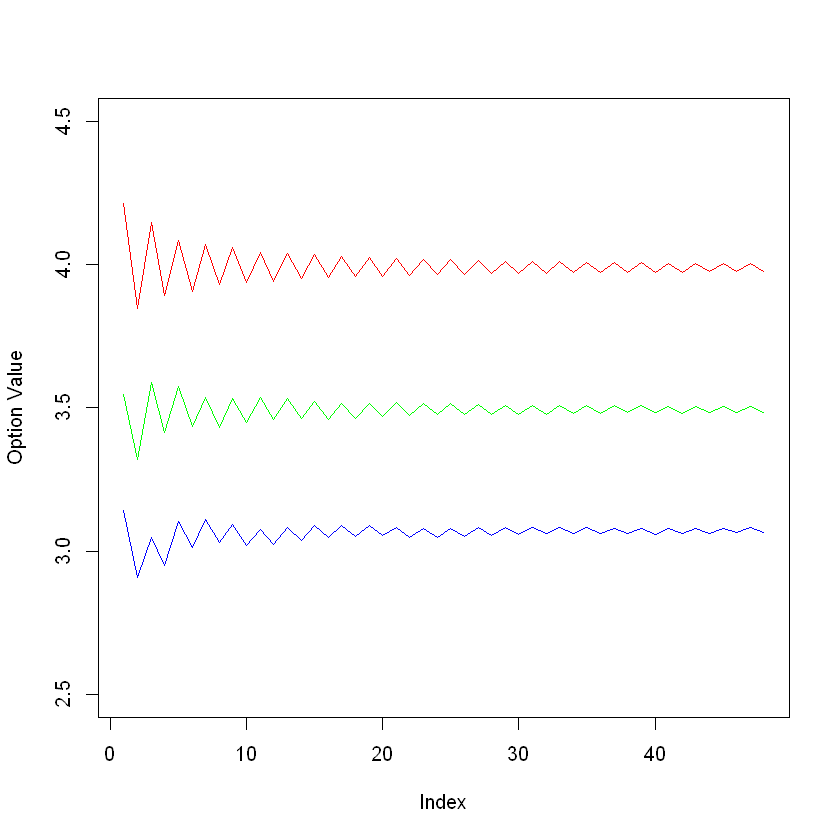

In [739]:
steps = 50
CRROptionValue =  CRROptionValue1 = CRROptionValue2 = rep(NA, times = steps)
for (n in 3:steps) { 
  CRROptionValue[n] = CRRBinomialTreeOption(TypeFlag = "pa", S = 50, 
                                            X = 50, Time = 0.4167, r = 0.4, b = 0.1, sigma = 0.4, n = n)@price
  CRROptionValue1[n] = CRRBinomialTreeOption(TypeFlag = "pa", S = 50, 
                                          X = 50, Time = 0.4167, r = 0.4, b = 0.2, sigma = 0.4, n = n)@price 
  CRROptionValue2[n] = CRRBinomialTreeOption(TypeFlag = "pa", S = 50, 
                                              X = 50, Time = 0.4167, r = 0.4, b = 0.3, sigma = 0.4, n = n)@price 
} 

plot(CRROptionValue[3:steps], type = "l", col = "red", ylab = "Option Value",ylim=c(2.5,4.5))
lines(CRROptionValue1[3:steps],type = "l", col = "green", ylab = "Option Value")
lines(CRROptionValue2[3:steps],type = "l", col = "blue", ylab = "Option Value")


# 3- Modélisation numérique du modèle Black & Scholes .
## 3.1-  Creation d'un modèle Black & Scholes From scratch 

In [740]:
BlackScholes <- function(S, K, r, T, sig, type){
  if(type=="C"){
    d1 <- (log(S/K) + (r + sig^2/2)*T) / (sig*sqrt(T))
    d2 <- d1 - sig*sqrt(T)
    
    value <- S*pnorm(d1) - K*exp(-r*T)*pnorm(d2)
    return(value)}
  
  if(type=="P"){
    d1 <- (log(S/K) + (r + sig^2/2)*T) / (sig*sqrt(T))
    d2 <- d1 - sig*sqrt(T)
    
    value <-  (K*exp(-r*T)*pnorm(-d2) - S*pnorm(-d1))
    return(value)}
}

#### 3.1.1- Modèle Black & Scholes Option Call

In [741]:
call <- BlackScholes(110,100,0.04,1,0.2,"C")
call

[1] 16.96868

#### 3.1.2- Modèle Black & Scholes Option Put

In [742]:
Put <- BlackScholes(110,100,0.04,1,0.2,"P")
Put

[1] 3.047622

### 3.2-  Creation d'un modèle Black & Scholes avec la bibliothèque qrmtools
#### 3.2.1- Modèle Black & Scholes Option Call

In [743]:
Black_Scholes(0, 110, 0.01, 0.2, 100, 1, "put")

[1] 3.949687

#### 3.2.2- Modèle Black & Scholes Option Call Avec les Indicateurs Grecs

In [744]:
Black_Scholes_Greeks(0, 110, 0.01, 0.2, 100, 1, "put")

delta        theta          rho         vega        gamma        vanna 
 -0.26547683  -3.27474763 -33.15213884  36.06269019   0.01490194  -0.69920786 
       vomma 
 48.18982446

#### 3.2.3- Modèle Black & Scholes Option Put

In [745]:
Black_Scholes(0, 110, 0.01, 0.2, 100, 1, "call")

[1] 14.9447

#### 3.2.1- Modèle Black & Scholes Option Put avec les Indicateurs Grecs

In [746]:
Black_Scholes_Greeks(0, 110, 0.01, 0.2, 100, 1, "call")

delta       theta         rho        vega       gamma       vanna 
 0.73452317 -4.26479746 65.85284453 36.06269019  0.01490194 -0.69920786 
      vomma 
48.18982446

# 4- Convergence de Cox-Rubinsteinau vers le modèle Black Scholes


In [747]:
Convergence = function(steps,type,type_b,S,X,Time, sigma, r, b,title) {
CRROptionValue  = rep(NA, times = steps)
for (n in 3:steps) { 
 CRROptionValue[n] = CRRBinomialTreeOption(TypeFlag = type, S = S, 
   X = X, Time = Time, r = r, b = b, sigma =sigma, n = n)@price
     
   }           
 plot(CRROptionValue[3:steps], type = "l", col = "blue", ylab = "Option Value",xlab="Step") #Black_Scholes(S, X, r, Time, sigma, b, type_b)
BAWValue =  BAWAmericanApproxOption(TypeFlag = type_b, S = S, 
X = X, Time = Time, r = r, b = b, sigma =sigma)@price
abline(h = BAWValue, lty =5,col="red")

title(main = title)
legend("topright", legend=c("COX-ROSS ","Black & Scholes"),col=c("blue","red"), lty=1:2, cex=0.8)
}

## 4.1-   Convergence Convergence d'un option Call Américain vers le modèle Black Scholes


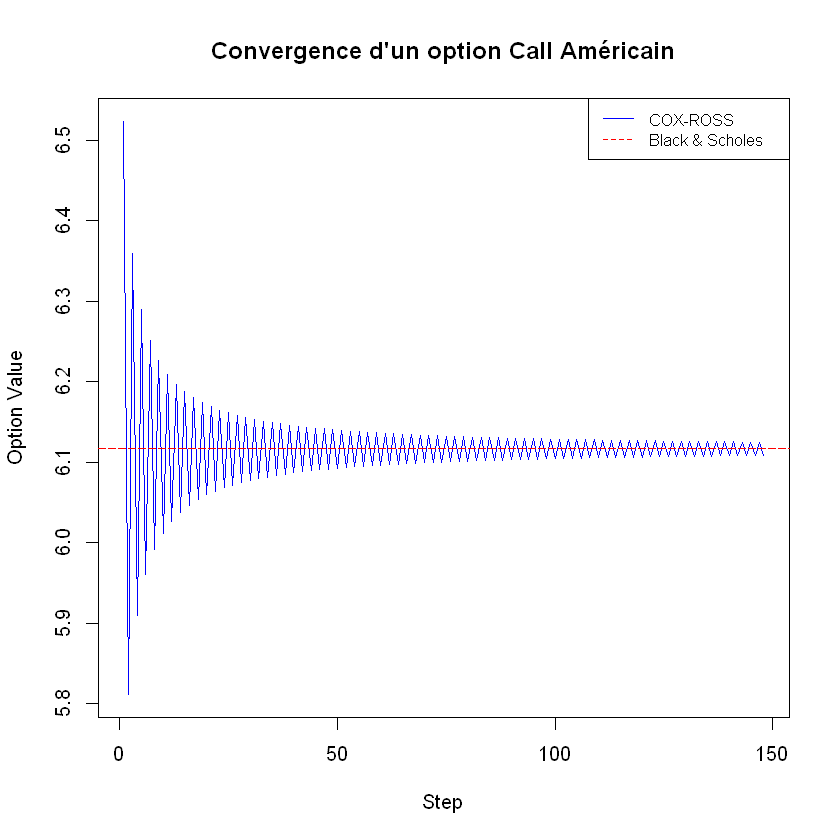

In [751]:
Convergence(steps=150,type="ca",type_b="c",S=50,X=50,Time=0.4167, sigma=0.4,  r=0.1, b=0.1,title="Convergence d'un option Call Américain")

## 4.1-   Convergence Convergence d'un option Put Américain vers le modèle Black Scholes

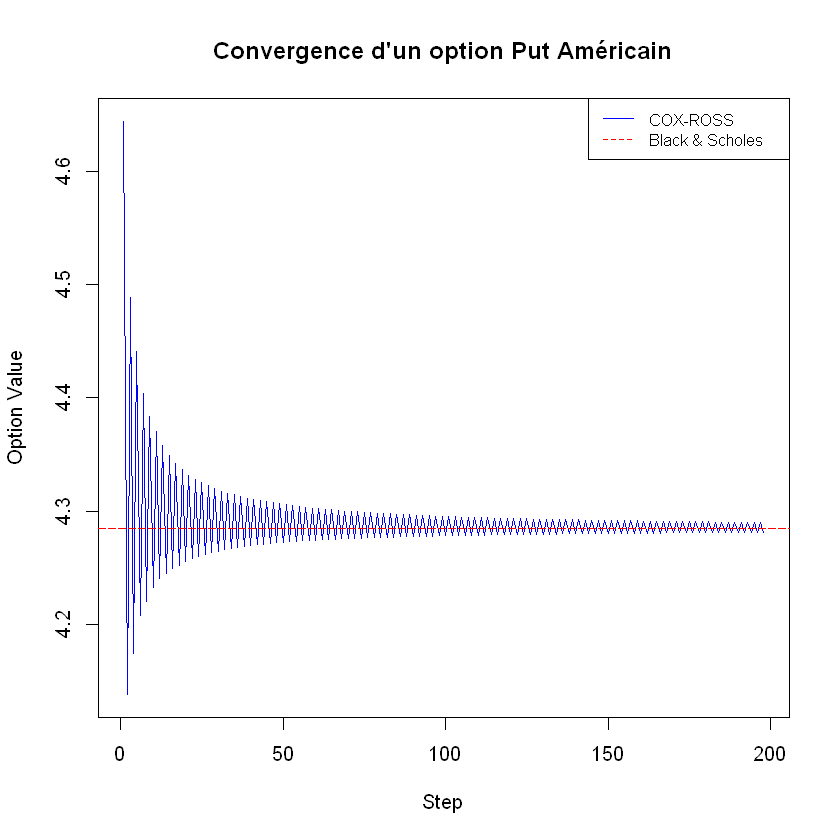

In [749]:
Convergence(steps=200,type="pa",type_b="p",S=50,X=50,Time=0.4167, sigma=0.4,  r=0.1, b=0.1,title="Convergence d'un option Put Américain")

## 4.3 Étude de la vitesse de convergence du Model CRR

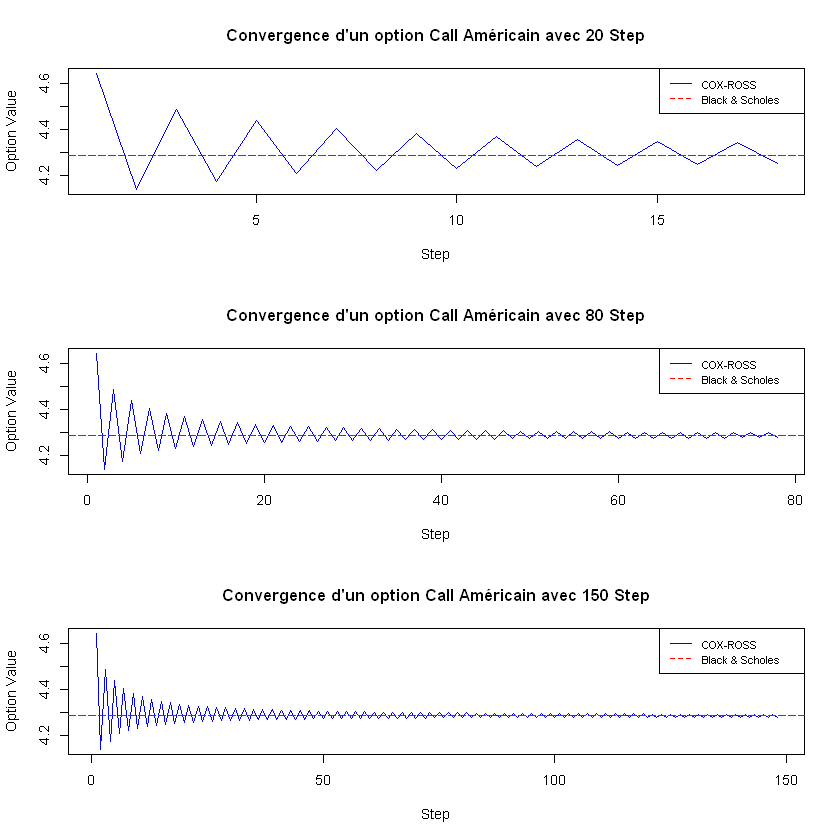

In [750]:
par(mfrow = c(3, 1), cex = 0.7)
Convergence(steps=20,type="pa",type_b="p",S=50,X=50,Time=0.4167, sigma=0.4,  r=0.1, b=0.1,title="Convergence d'un option Call Américain avec 20 Step")
Convergence(steps=80,type="pa",type_b="p",S=50,X=50,Time=0.4167, sigma=0.4,  r=0.1, b=0.1,title="Convergence d'un option Call Américain avec 80 Step")
Convergence(steps=150,type="pa",type_b="p",S=50,X=50,Time=0.4167, sigma=0.4,  r=0.1, b=0.1,title="Convergence d'un option Call Américain avec 150 Step")